# Momentum Strategies

Momentum or trend-following strategies refer to trading strategies that rely on following a price trend to completion for profit. An example of a price trend is a sustained price increase due to good earnings beating expectations. 

Momentum strategies use various technical indicators to open a trade when a trend begins and exits when the trend ends. These strategies can be long or short. Momentum strategies is usually contrasted with mean-reversion strategies where traders believe that prices should revert to an expected value. An example of a mean reversion strategy is pairs trading.

Momentum strategies are generally characterised by a low win-rate due to whipsaw losses (indicated trends did not materialise) with great returns from a few winning trades, compared to lower, but more consistent profits for mean reversion trades. This generally produces a lower sharpe ratio for momentum strategies.

Technical indicators for entry include:
- Moving average crossover
- Breakout from highest value in rolling window
- Breakout from All-Time-High

Exit indicators include:
- Moving average crossover
- Breakout from lowest value in rolling window
- Trailing stop



In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from utils import misc
import datetime as dt
from trade_obj import *
from simple_backtester import backTester
from mpl_toolkits.mplot3d import Axes3D



ticker = 'SPY'
df = pd.read_csv('datasets/stock_price_series/' + ticker + '.csv')
df = misc.clean_df(df)
df = df.set_index('date')

Generate indicators for entry and exit

In [96]:
def generate_high_low(df, high_window, low_window):

    df['up_bound'] = df['high'].shift(1).rolling(high_window).max()
    df['low_bound'] = df['low'].shift(1).rolling(low_window).min()

    return df

def generate_atr(df, window):
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window).mean()

    return df

def generate_sma(df, long_window, short_window):
    df['long_sma'] = df['close'].rolling(long_window).mean().shift(2)
    df['short_sma'] = df['close'].rolling(short_window).mean().shift(2)

    return df

# df = df.dropna()

# convert to np array to save time
# ub = df['up_bound'].to_numpy()
# lb = df['low_bound'].to_numpy()
# atr = df['ATR'].to_numpy()




# df = df[-1000:]

### Moving Average Crossover

The moving average crossover consists of 2 moving averages, one with a short period and one with a long period. The strategy opens a long trade when the short moving average crosses above the long moving average and closes the trade when the short moving average crosses under the long moving average.

In [97]:
def ma_backtest(df, long_window, short_window):

    df = generate_sma(df, long_window, short_window)
    df.dropna(inplace=True)

    
    df['signal'] = 0

    # Generate trading signals
    df.loc[df['short_sma'].shift(1) > df['long_sma'].shift(1), 'signal'] = 1
    # df.loc[df['short_ma'].shift(1) < df['long_ma'].shift(1), 'signal'] = 0

    trades_arr = df['signal'].diff().to_numpy()

    bt = backTester()
    bt.set_asset(df)

    tl = tradeList()

    open_trade = None

    for i in range(len(bt.df)):
        
        order_quantity = 0
        order_price = 0

        if trades_arr[i] == 1:
    
            # order price at breakout
            order_price = bt.open[i]
            # order 1 unit
            order_quantity = bt.cash // order_price
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity)
            

        # open trades present 
        elif trades_arr[i] == -1:

            order_price = bt.open[i]
            order_quantity = -open_trade.quantity
                
            open_trade.close(bt.date[i], order_price)
            tl.append(open_trade)
            
            open_trade = None

        bt.take_action(order_quantity=order_quantity, order_price=order_price)
    
    return bt
                



In [98]:
ma_period = np.arange(1, 501, 5)
results = []

for i in range(len(ma_period)):
    for j in range(i + 1, len(ma_period)):
        # print(i, j)
        bt = ma_backtest(df.copy(), ma_period[j], ma_period[i])
        bt.analyse()
        results.append((ma_period[j], ma_period[i], bt.annual_return, bt.annual_vol, bt.sharpe))

In [99]:
print('Buy Hold Results')
print(f'Annual Return = {bt.buy_hold_annual_return}')
print(f'Annual Volatility = {bt.buy_hold_annual_vol}')
print(f'Sharpe Ratio = {bt.buy_hold_sharpe}')
print('-----------')
best_sr = max(results, key=lambda x: x[4])
print(f'Max Sharpe Ratio:')
print(f'Long MA Window = {best_sr[0]}, Short MA Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')
best_sr = max(results, key=lambda x: x[2])
print(f'Max Total Returns:')
print(f'Long MA Window = {best_sr[0]}, Short MA Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')

Buy Hold Results
Annual Return = 0.1505776499866609
Annual Volatility = 0.19344900667102036
Sharpe Ratio = 0.7783841983884334
-----------
Max Sharpe Ratio:
Long MA Window = 321, Short MA Window = 101
Annual Return = 0.1372406377594413
Annual Volatility = 0.1452727776660867
Sharpe Ratio = 0.9447099447282029
-----------
Max Total Returns:
Long MA Window = 491, Short MA Window = 106
Annual Return = 0.1402399707293065
Annual Volatility = 0.1520888648381778
Sharpe Ratio = 0.9220922970167573
-----------


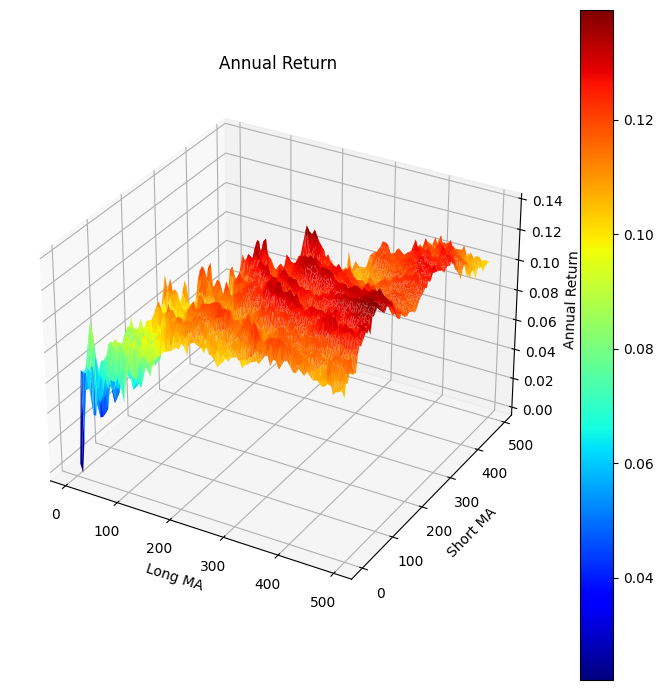

In [100]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[2] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('Long MA')
ax.set_ylabel('Short MA')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Return')

fig.tight_layout()

plt.show()

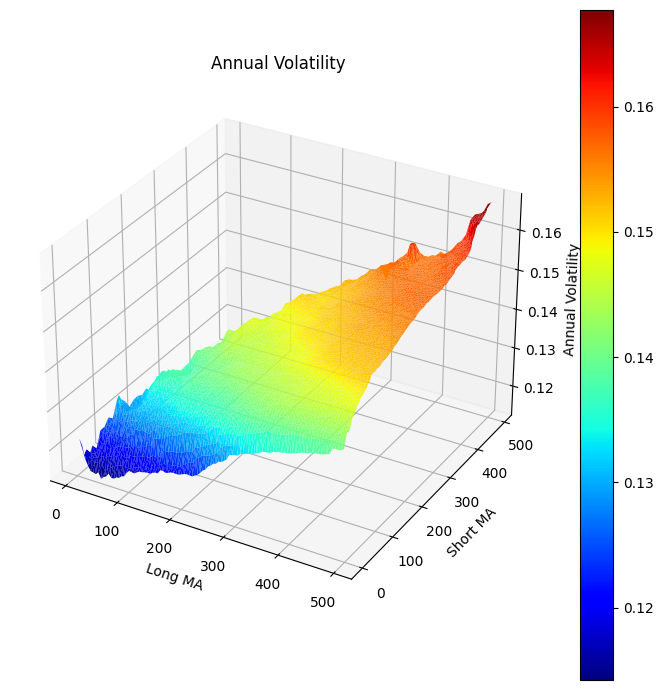

In [101]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[3] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('Long MA')
ax.set_ylabel('Short MA')
ax.set_zlabel('Annual Volatility')
ax.set_title('Annual Volatility')

fig.tight_layout()

plt.show()

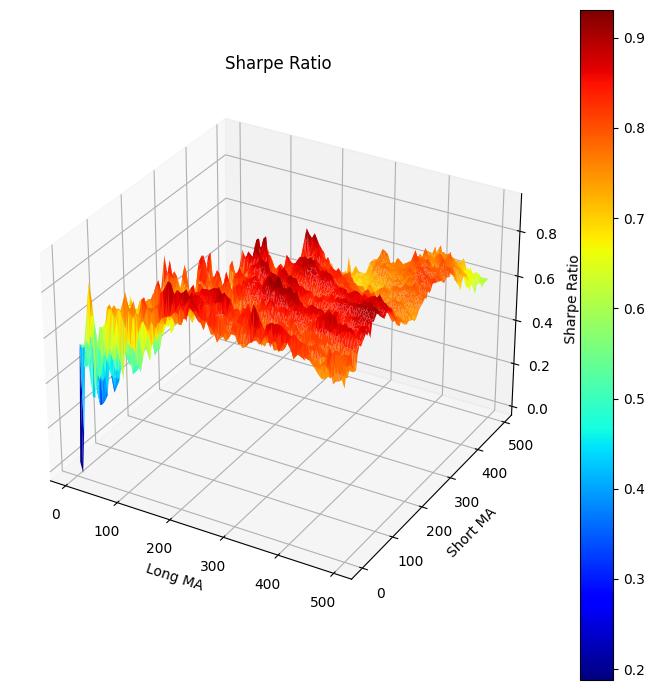

In [102]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[4] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('Long MA')
ax.set_ylabel('Short MA')
ax.set_zlabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio')

fig.tight_layout()

plt.show()

### High/Low Breakout

In [103]:
def hl_backtest(df, high_window, low_window):

    df = generate_high_low(df, high_window, low_window)

    df.dropna(inplace=True)

    df['signal'] = 0

    # Generate trading signals
    df.loc[df['high'].shift(1) > df['up_bound'].shift(2), 'signal'] = 1
    df.loc[df['low'].shift(1) < df['low_bound'].shift(2), 'signal'] = -1
    

    trades_arr = df['signal'].to_numpy()

    bt = backTester()
    bt.set_asset(df)

    tl = tradeList()

    open_trade = None

    for i in range(len(bt.df)):
        
        order_quantity = 0
        order_price = 0

        if trades_arr[i] == 1 and open_trade == None:
    
            # order price at breakout
            order_price = bt.open[i]
            # order 1 unit
            order_quantity = bt.cash // order_price
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity)
            

        # open trades present 
        elif trades_arr[i] == -1 and open_trade != None:

            order_price = bt.open[i]
            order_quantity = -open_trade.quantity
                
            open_trade.close(bt.date[i], order_price)
            tl.append(open_trade)
            
            open_trade = None

        bt.take_action(order_quantity=order_quantity, order_price=order_price)
        
    
    return bt, tl

In [104]:
hl_period = np.arange(1, 101, 1)
results = []

for i in range(len(hl_period)):
    for j in range(len(hl_period)):
        # print(i, j)
        bt, _ = hl_backtest(df.copy(), hl_period[i], hl_period[j])
        bt.analyse()
        results.append((hl_period[i], hl_period[j], bt.annual_return, bt.annual_vol, bt.sharpe))

In [105]:
print('Buy Hold Results')
print(f'Annual Return = {bt.buy_hold_annual_return}')
print(f'Annual Volatility = {bt.buy_hold_annual_vol}')
print(f'Sharpe Ratio = {bt.buy_hold_sharpe}')
print('-----------')
best_sr = max(results, key=lambda x: x[4])
print(f'Max Sharpe Ratio:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')
best_sr = max(results, key=lambda x: x[2])
print(f'Max Total Returns:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')

Buy Hold Results
Annual Return = 0.14766447442066544
Annual Volatility = 0.18954553227668172
Sharpe Ratio = 0.7790448693093855
-----------
Max Sharpe Ratio:
High Window = 94, Low Window = 95
Annual Return = 0.10672558881723648
Annual Volatility = 0.11314232856647102
Sharpe Ratio = 0.9432861261515869
-----------
Max Total Returns:
High Window = 3, Low Window = 95
Annual Return = 0.1251701251772881
Annual Volatility = 0.1681418687605235
Sharpe Ratio = 0.7444316284813152
-----------


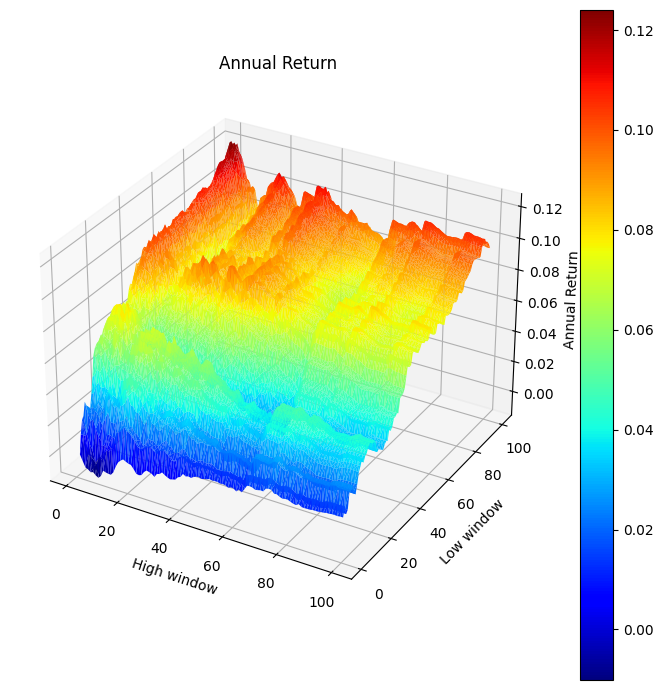

In [106]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[2] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Return')

fig.tight_layout()

plt.show()

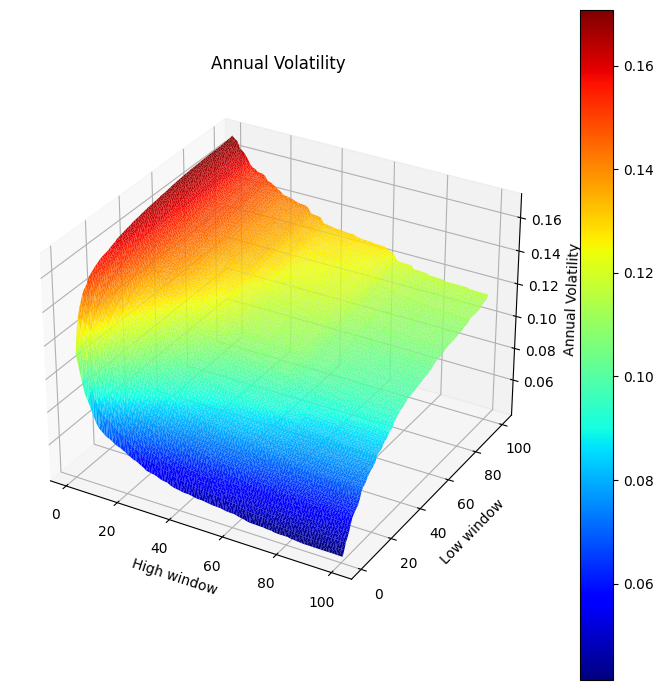

In [107]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[3] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Volatility')
ax.set_title('Annual Volatility')

fig.tight_layout()

plt.show()

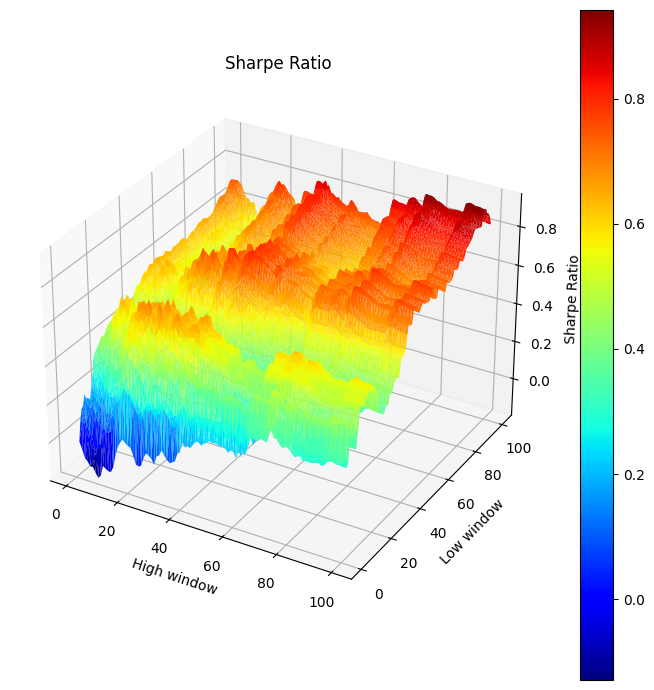

In [108]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[4] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio')

fig.tight_layout()

plt.show()

### High Window with trailing stop loss

In [109]:
def hatr_backtest(df, high_window, atr_window, atr_multiple):

    df = generate_high_low(df, high_window, 10)
    df = generate_atr(df, atr_window)
    df['ATR'] = df['ATR'].shift(1)
    atr = df['ATR'].to_numpy()

    df.dropna(inplace=True)

    df['signal'] = 0

    # Generate trading signals
    df.loc[df['high'].shift(1) > df['up_bound'].shift(2), 'signal'] = 1    

    trades_arr = df['signal'].to_numpy()

    bt = backTester()
    bt.set_asset(df)

    tl = tradeList()

    open_trade = None
    stop_loss = np.nan
    stop_arr = []
    

    for i in range(len(bt.df)):
        
        order_quantity = 0
        order_price = 0
        

        if trades_arr[i] == 1 and open_trade == None:
    
            # order price at breakout
            order_price = bt.open[i]
            # order 1 unit
            order_quantity = bt.cash // order_price
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity)
            n3 = atr_multiple * atr[i]
            stop_loss = order_price - n3
        # open trades present 
        elif open_trade != None:
            stop_loss = max(stop_loss, bt.high[i] - n3)
            if bt.low[i] < stop_loss:

                order_price = stop_loss
                order_quantity = -open_trade.quantity
                    
                open_trade.close(bt.date[i], order_price)
                tl.append(open_trade)
                
                open_trade = None
                stop_loss = np.nan
        
        stop_arr.append(stop_loss)

        bt.take_action(order_quantity=order_quantity, order_price=order_price)
    bt.df['stop_loss'] = stop_arr

    return bt, tl

In [110]:
hl_period = np.arange(5, 501, 5)
atr_range = np.arange(1, 11, 1)
results = []

for i in range(len(hl_period)):
    for j in range(len(atr_range)):
        # print(i, j)
        bt, _ = hatr_backtest(df.copy(), hl_period[i], 40, atr_range[j])
        bt.analyse()
        results.append((hl_period[i], atr_range[j], bt.annual_return, bt.annual_vol, bt.sharpe))

In [111]:
print('Buy Hold Results')
print(f'Annual Return = {bt.buy_hold_annual_return}')
print(f'Annual Volatility = {bt.buy_hold_annual_vol}')
print(f'Sharpe Ratio = {bt.buy_hold_sharpe}')
print('-----------')
best_sr = max(results, key=lambda x: x[4])
print(f'Max Sharpe Ratio:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')
best_sr = max(results, key=lambda x: x[2])
print(f'Max Total Returns:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')

Buy Hold Results
Annual Return = 0.1510179826977729
Annual Volatility = 0.19348402485693794
Sharpe Ratio = 0.7805191297288526
-----------
Max Sharpe Ratio:
High Window = 95, Low Window = 10
Annual Return = 0.11590583032761392
Annual Volatility = 0.1274165391143
Sharpe Ratio = 0.9096607954767919
-----------
Max Total Returns:
High Window = 500, Low Window = 1
Annual Return = 0.11937322646871329
Annual Volatility = 0.19380600808484913
Sharpe Ratio = 0.6159418257892767
-----------


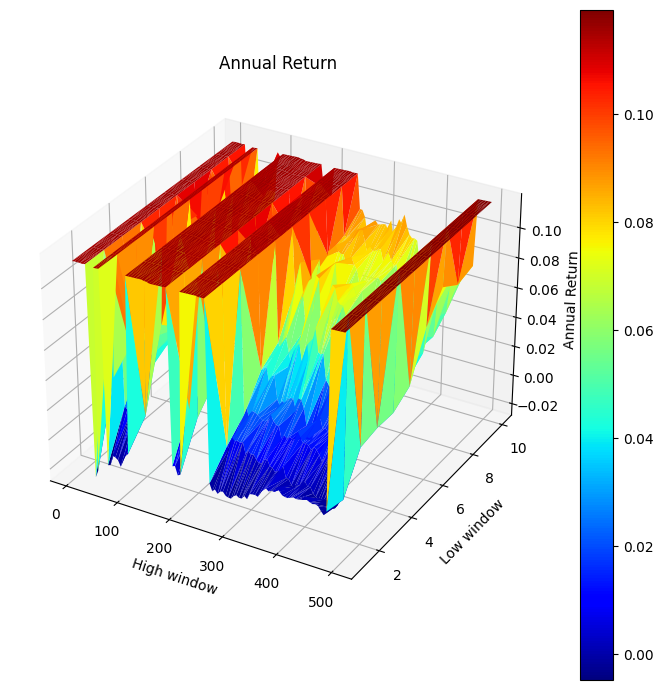

In [112]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[2] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Return')

fig.tight_layout()

plt.show()

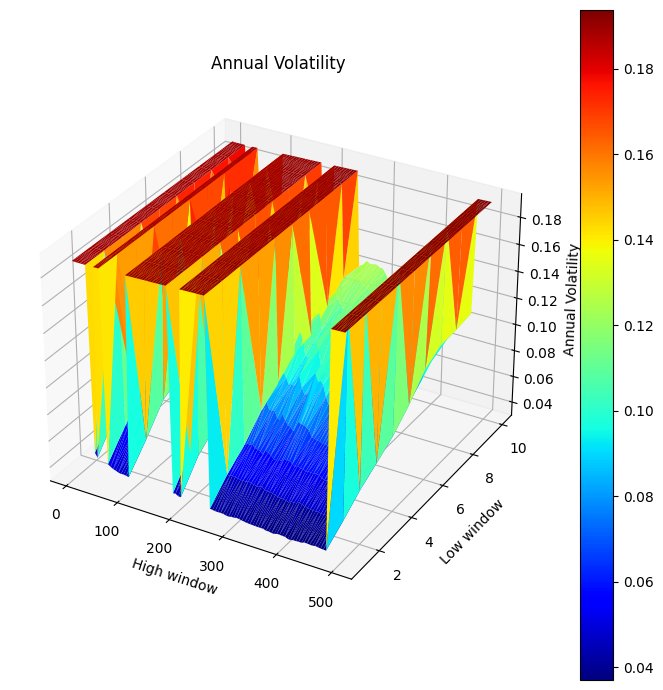

In [113]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[3] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Volatility')
ax.set_title('Annual Volatility')

fig.tight_layout()

plt.show()

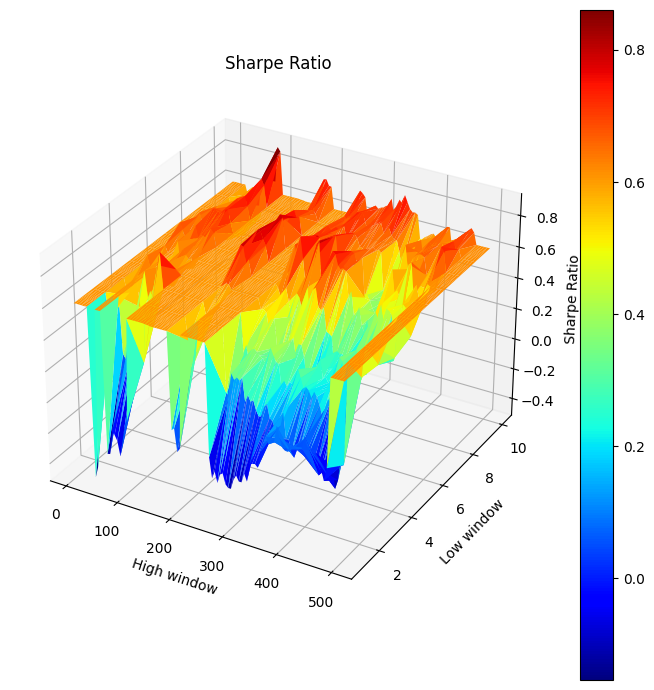

In [114]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[4] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio')

fig.tight_layout()

plt.show()

In [115]:
def ma_atr_backtest(df, long_window, short_window, atr_window, atr_multiple):

    df = generate_sma(df, long_window=long_window, short_window=short_window)
    df = generate_atr(df, atr_window)
    df['ATR'] = df['ATR'].shift(1)
    atr = df['ATR'].to_numpy()

    df.dropna(inplace=True)


    # Generate trading signals
    df['signal'] = 0

    # Generate trading signals
    df.loc[df['short_sma'].shift(1) > df['long_sma'].shift(1), 'signal'] = 1

    trades_arr = df['signal'].diff().to_numpy()

    bt = backTester()
    bt.set_asset(df)

    tl = tradeList()

    open_trade = None
    stop_loss = np.nan
    stop_arr = []
    

    for i in range(len(bt.df)):
        
        order_quantity = 0
        order_price = 0
        

        if trades_arr[i] == 1 and open_trade == None:
    
            # order price at breakout
            order_price = bt.open[i]
            # order 1 unit
            order_quantity = bt.cash // order_price
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity)
            n3 = atr_multiple * atr[i]
            stop_loss = order_price - n3
            
        # open trades present 
        elif open_trade != None:
            stop_loss = max(stop_loss, bt.high[i] - n3)
            if bt.low[i] < stop_loss:

                order_price = stop_loss
                order_quantity = -open_trade.quantity
                    
                open_trade.close(bt.date[i], order_price)
                tl.append(open_trade)
                
                open_trade = None
                stop_loss = np.nan
        
        stop_arr.append(stop_loss)

        bt.take_action(order_quantity=order_quantity, order_price=order_price)
    bt.df['stop_loss'] = stop_arr

    return bt, tl

In [116]:
short_window = 10
ma_period = np.arange(short_window + 10, 501, 5)
atr_range = np.arange(1, 11, 1)
results = []

for i in range(len(ma_period)):
    for j in range(len(atr_range)):
        bt, _ = ma_atr_backtest(df.copy(), ma_period[i], short_window, 20, atr_range[j])
        bt.analyse()
        results.append((ma_period[i], atr_range[j], bt.annual_return, bt.annual_vol, bt.sharpe))

In [117]:
print('Buy Hold Results')
print(f'Annual Return = {bt.buy_hold_annual_return}')
print(f'Annual Volatility = {bt.buy_hold_annual_vol}')
print(f'Sharpe Ratio = {bt.buy_hold_sharpe}')
print('-----------')
best_sr = max(results, key=lambda x: x[4])
print(f'Max Sharpe Ratio:')
print(f'Long MA Window = {best_sr[0]}, Short MA Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')
best_sr = max(results, key=lambda x: x[2])
print(f'Max Total Returns:')
print(f'Long MA Window = {best_sr[0]}, Short MA Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')

Buy Hold Results
Annual Return = 0.15096192250657547
Annual Volatility = 0.1934974861020444
Sharpe Ratio = 0.7801751100113155
-----------
Max Sharpe Ratio:
Long MA Window = 360, Short MA Window = 8
Annual Return = 0.09167932574759718
Annual Volatility = 0.09767696851127972
Sharpe Ratio = 0.9385971651752283
-----------
Max Total Returns:
Long MA Window = 460, Short MA Window = 1
Annual Return = 0.12216100266749219
Annual Volatility = 0.19340300186619103
Sharpe Ratio = 0.6316396410021146
-----------


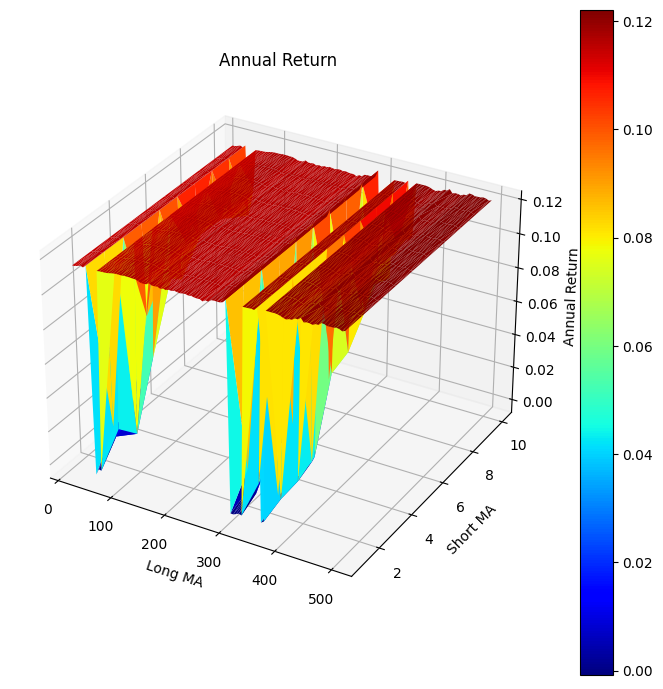

In [118]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[2] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('Long MA')
ax.set_ylabel('Short MA')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Return')

fig.tight_layout()

plt.show()

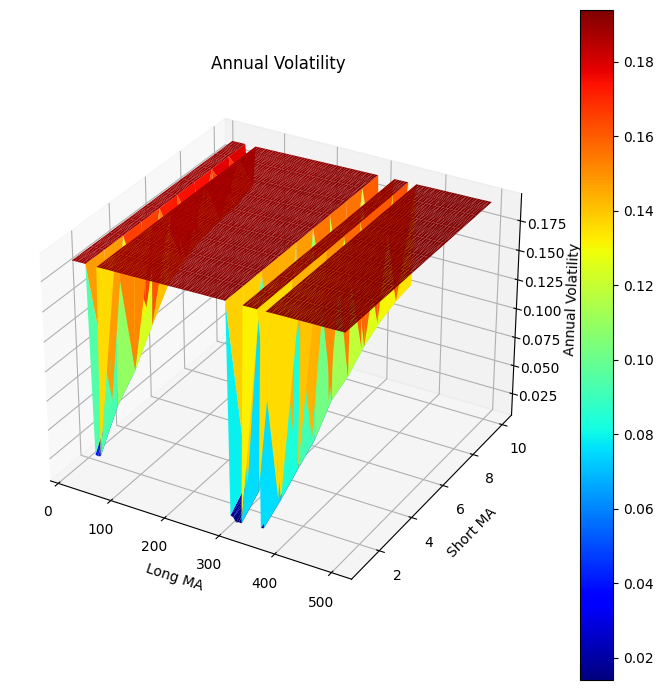

In [119]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[3] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('Long MA')
ax.set_ylabel('Short MA')
ax.set_zlabel('Annual Volatility')
ax.set_title('Annual Volatility')

fig.tight_layout()

plt.show()

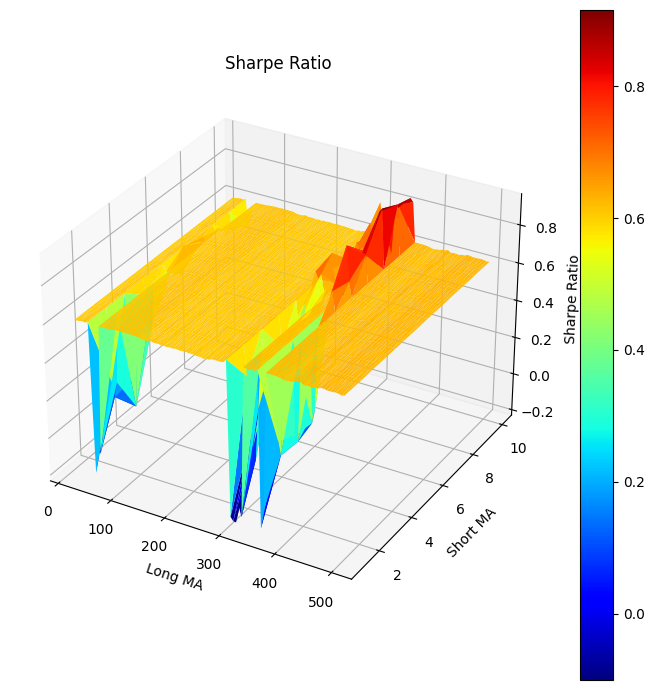

In [120]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[4] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('Long MA')
ax.set_ylabel('Short MA')
ax.set_zlabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio')

fig.tight_layout()

plt.show()

### Portfolio Stats

This section looks at the stats of a portfolio that runs this trade at no leverage.

This portfolio has lower returns and lower volatility/drawdowns compared to a buy-hold strategy. The portfolio manages to avoid the large drawdown events, thus preserving capital.

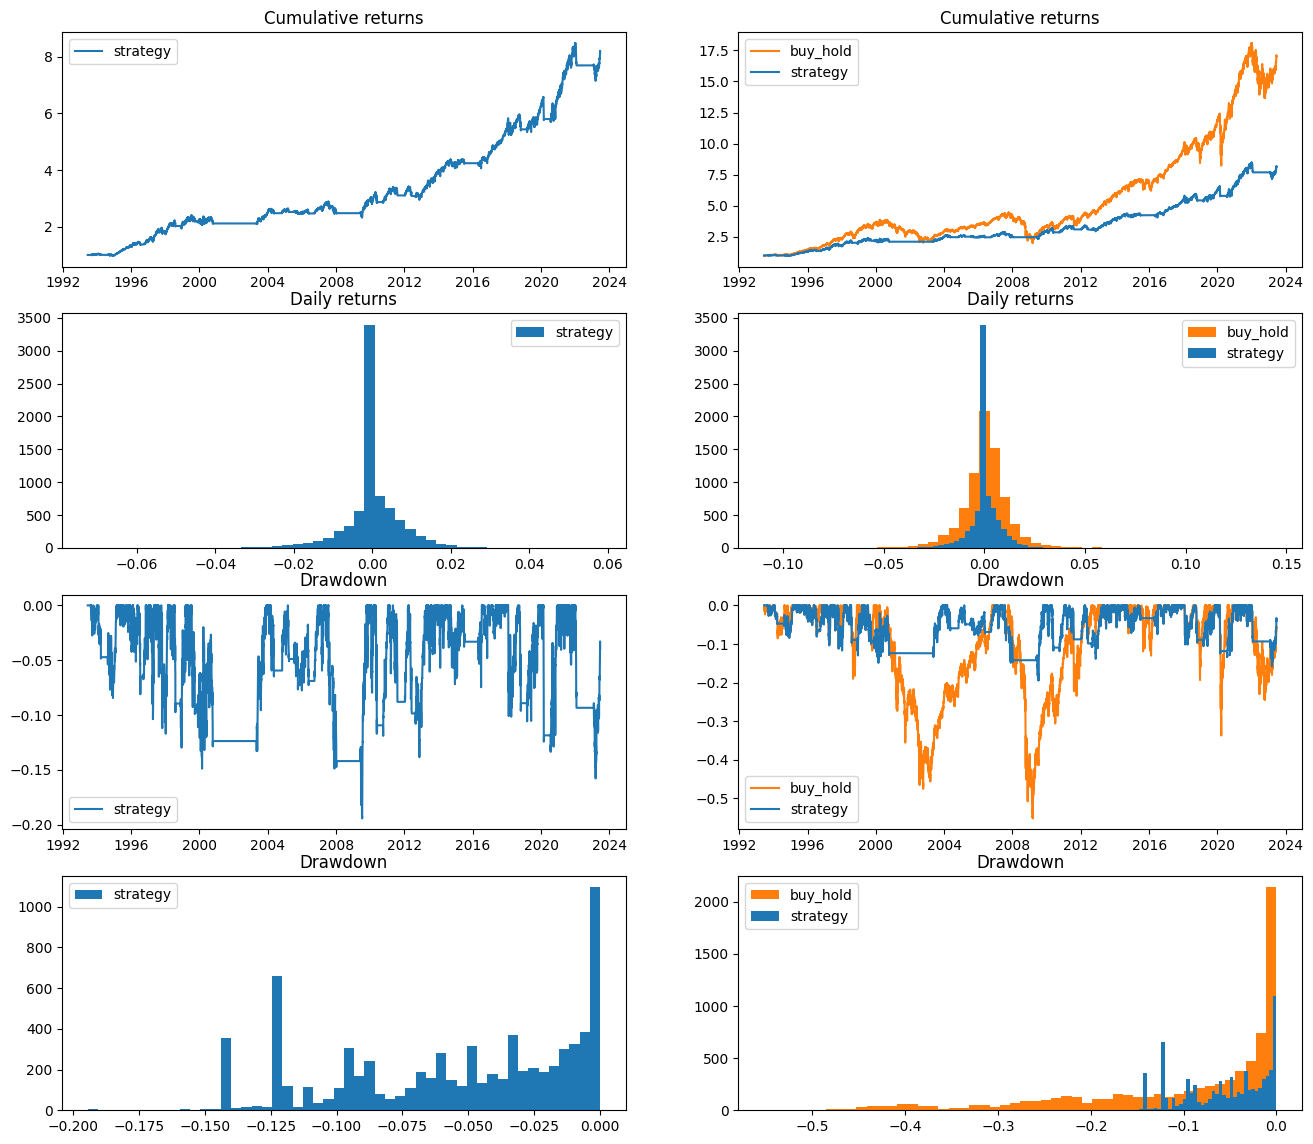

In [126]:
bt, tl = hl_backtest(df.copy(), 94, 95)

bt.analyse()
bt.plot_graphs()

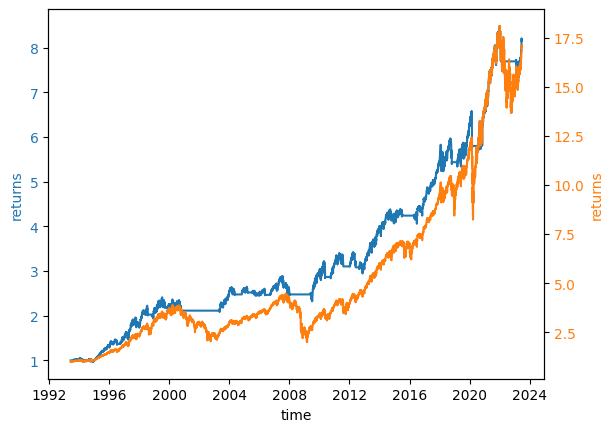

In [127]:
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_facecolor('xkcd:white')
plt.show()

In [123]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print('---------')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print('---------')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.09833224983543576
buy_hold annual return:     0.1470365338277959
---------
Annualised vol:             0.14325475595041268
buy_hold annual vol:        0.18948621222239426
---------
Sharpe ratio:               0.6864152549983977
buy_hold Sharpe ratio:      0.7759748432525717


### Trade record stats

This section looks at the backtest results on a trade-by-trade basis.

In [128]:
tl.analyse(bt.df)
tl.stats

{'num_wins': 16,
 'num_loss': 4,
 'win_rate': 0.8,
 'profit_total': 6692121.82774353,
 'profit_mean': 334606.09138717654,
 'returns_mean': 0.11579174671203349,
 'returns_std': 0.1432567753394162,
 'time_in_trade_mean': 354.3,
 'time_in_trade_std': 225.63736625973894,
 'capital_at_risk_mean': 2765020.653857422,
 'win_returns_mean': 0.15427631298519914,
 'win_returns_std': 0.13367281139847367,
 'win_profit_mean': 442818.095805645,
 'win_time_in_trade_mean': 402.125,
 'win_time_in_trade_std': 222.84430289628975,
 'loss_returns_mean': -0.038146518380629164,
 'loss_returns_std': 0.03374569121156206,
 'loss_profit_mean': -98241.92628669731,
 'loss_time_in_trade_mean': 163.0,
 'loss_time_in_trade_std': 114.68798251487962}

We plot every single trade to view the characteristics of each trade.

trade 0
entry: [45.8125]
cost_basis: 45.8125
exit: 46.0
returns: 0.004092769440654843


KeyError: 'stop_loss'

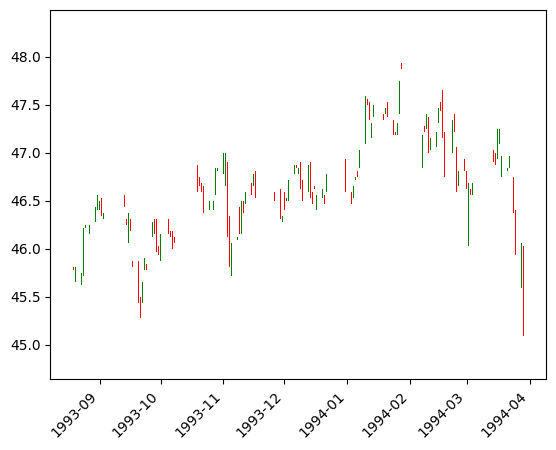

In [129]:
tl.plot_all_trades()

We can plot the trades that occur over a specific period of time to see how this strategy perform.

KeyError: 'stop_loss'

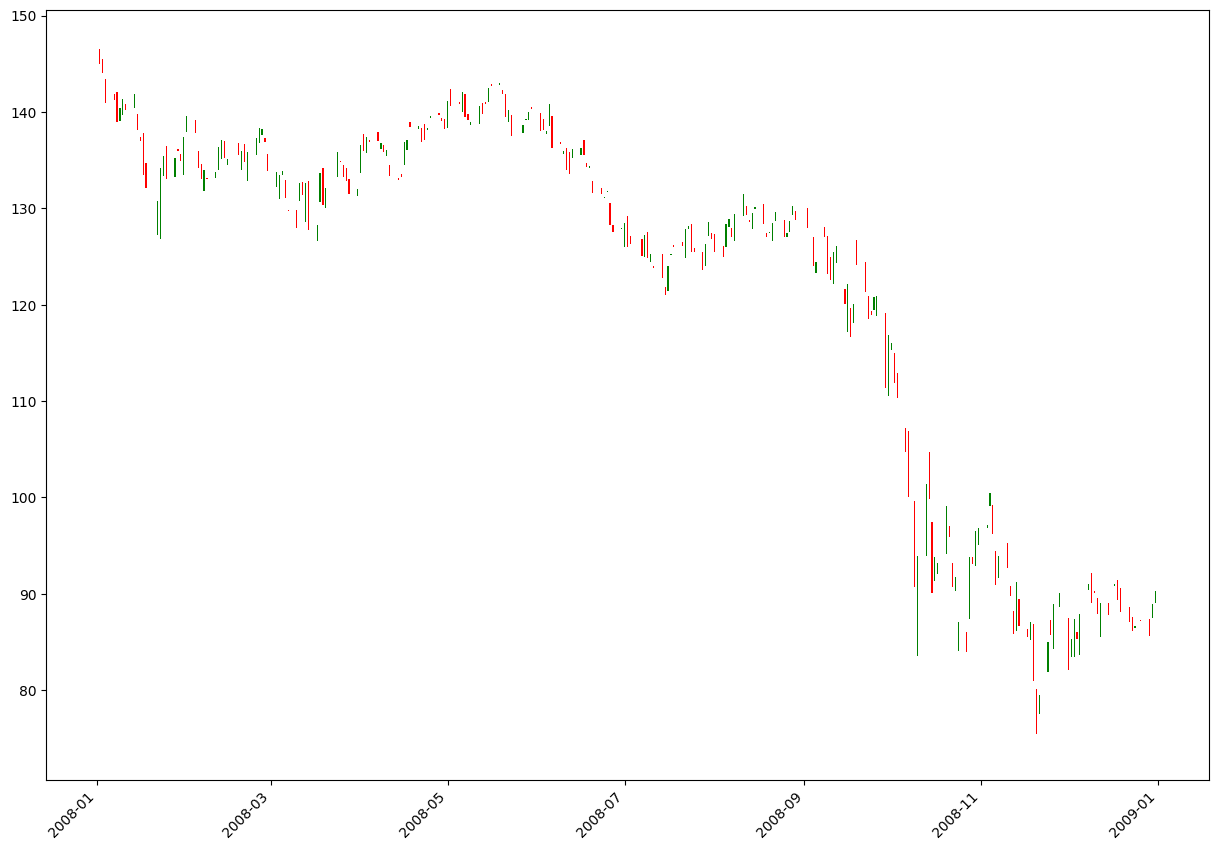

In [ ]:

start_datetime= pd.to_datetime(dt.date(2008, 1, 1))
end_datetime = pd.to_datetime(dt.date(2009, 1, 1))

tl.plot_time_period(df, start_datetime, end_datetime)

We note that the time in trade for winning trades is generally higher than that of losing trades.

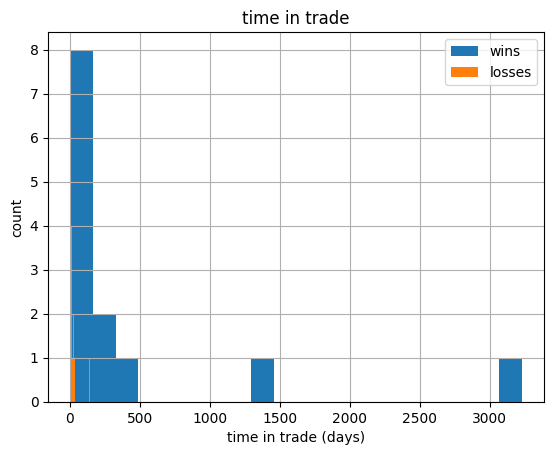

In [ ]:
tl.win_records['time_in_trade'].hist(bins=20, label='wins')
tl.loss_records['time_in_trade'].hist(bins=20, label='losses')
plt.xlabel('time in trade (days)')
plt.ylabel('count')
plt.title('time in trade')
plt.legend()
plt.show()

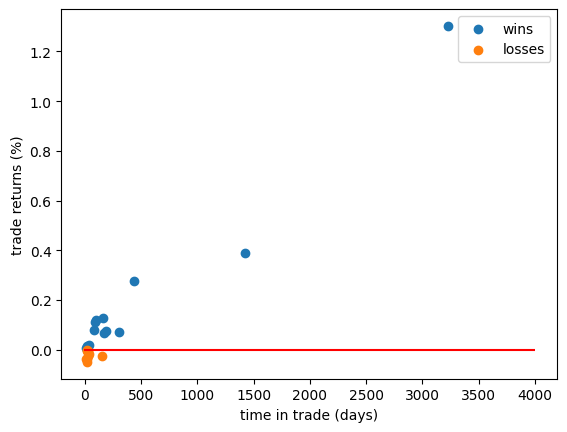

In [ ]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'], label='wins')
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'], label='losses')
plt.hlines(0, -10, 4000, color='red')
plt.legend()
plt.xlabel('time in trade (days)')
plt.ylabel('trade returns (%)')
plt.show()

### Analysis

We note that the turtle trading rules follow a trend-following or momentum trading strategy. The characteristic of these strategies is greater volatility, with lower win-rate but higher returns per winning trade.

Ideally, the strategy goes long when a long-term upward trend is established and follows the trend until it is exhausted, while avoiding big drawdowns when long-term downward trends are established. 

The downside to this strategy is that short-term volatility is likely to cause whipsaw losses. An example of this is losses when the underlying is trading within a range.

Therefore, the way to optimise this strategy is to pick the underlying to more frequent long-term trends with greater magnitude compared to short-term volatility. It does not matter which direction that long-term trend is in since we can just inverse the rules, e.g. go short when price breaks out under the 20-day low. This is also possibly why the original turtle traders focused on commodity trading, since commodities tend to exhibit trends based on the physical demand and supply of the commodity, whereas equities may be more volatile in the short-term due to speculation.

Another key part to the success of this strategy is to trade diversified and uncorrelated assets so that the various assets will be trending at different times. This will go a long way towards reducing the volatility of a portfolio trading all of these assets.

Another idea is to trade this strategy on leveraged ETFs, for example UPRO (3 x leveraged SP500) instead of trading on SPY. The nature of the ETF (3 x daily returns) is likely to cause the magnitude of long-term trends to increase significantly, thus increasing the returns per winning trade of this strategy. The volatility drag of the leverage should also reduce the number of whipsaw losing trades. Therefore, the overall profitability of this strategy on leveraged ETFs should increase. More testing is required however, since we have to account for a higher expense ratio, tracking error, and a lack of historical data since these ETFs are a relatively recent invention.